In [17]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from scipy import ndimage
from skimage.filters import threshold_otsu, threshold_local
from skimage.measure import label, regionprops
from skimage import io
from skimage import measure

# load data 
example_injury_fname = 'example_data/injury_singleslice.tif'
example_control_fname = 'example_data/control_singleslice.tif'

img_injury = io.imread(example_injury_fname)
img_control = io.imread(example_control_fname)

# set up code parameters
xy_res = 0.5772 # units of microns per pixel 
min_myofibril_length = 6 # microns

Text(0.5, 1.0, 'injury example, value: 244')

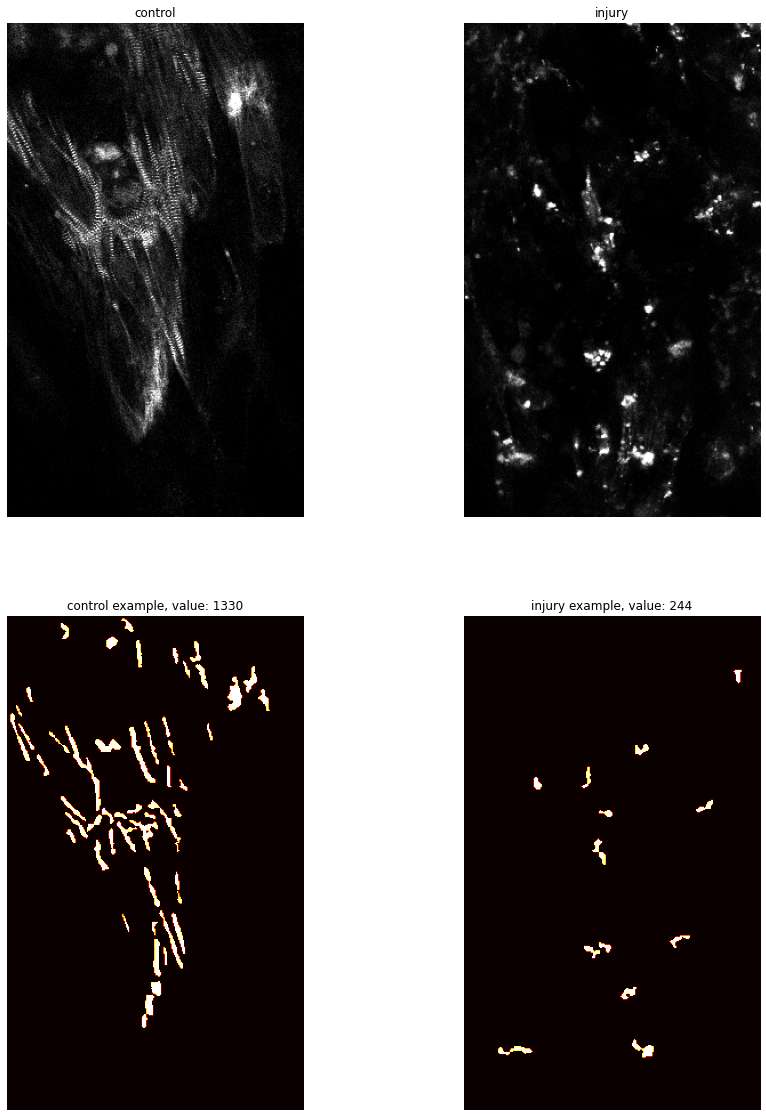

In [26]:
# define segmentation function
def segment_myofibrils(img_array,xy_res,min_myofibril_length):
    """
    input: image array (2D slice)
    xy_res: image resolution in microns per pixel 
    min_myofibril_length: minimum length for a component to be segmented
    """
    min_leng_pixels = min_myofibril_length / xy_res
    gaussian_filter_size = 2
    laplacian = cv2.Laplacian(img_array,cv2.CV_64F) # apply laplacian filter
    laplacian = ndimage.gaussian_filter(laplacian, gaussian_filter_size) # apply gaussian filter 
    thresh_lap = threshold_otsu(laplacian)
    lap_thresh = laplacian < thresh_lap # threshold laplacian filter image 
    frame_median = ndimage.median_filter(img_array,size=3)
    img_median_thresh = threshold_otsu(frame_median)
    remove_speckle = frame_median > img_median_thresh
    lap_thresh = lap_thresh * remove_speckle # remove speckle noise (present in some images) 
    label_img = label(lap_thresh) # label image
    regions = regionprops(label_img)
    segmented_myofibrils = [] 
    segmented_ix = [] 
    for props in regions: # loop through the labeled regions
        major_axis = props.major_axis_length
        minor_axis = props.minor_axis_length
        area = props.area 
        ang = props.orientation
        ix = props.label
        if area < 3 or minor_axis == 0:
            continue # region is likely noise 
        elif major_axis < min_leng_pixels:
            continue # region is not long enough to qualify as a segmented myofibril 
        else:
            segmented_myofibrils.append(major_axis)
            segmented_ix.append(props.label) # save region 
    
    total_weight = np.sum(segmented_myofibrils)
    
    segmented_regions = np.zeros(label_img.shape)
    for kk in range(0,len(segmented_ix)):
        segmented_regions += label_img == segmented_ix[kk]
    
    return total_weight, segmented_regions

######################################################
# segment control image 
# note: for 3D images, each 2D slice is segmented and the total weight is summed
######################################################
total_weight_control, segmented_regions_control = segment_myofibrils(img_control,xy_res,min_myofibril_length)

######################################################
# segment injury image
# note: for 3D images, each 2D slice is segmented and the total weight is summed
######################################################
total_weight_injury, segmented_regions_injury = segment_myofibrils(img_injury,xy_res,min_myofibril_length)

######################################################
# visualize results 
######################################################
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.imshow(img_control,cmap=plt.cm.gray)
plt.title('control')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(segmented_regions_control,cmap=plt.cm.hot)
plt.axis('off')
plt.title('control example, value: %i'%(total_weight_control))
plt.subplot(2,2,2)
plt.imshow(img_injury,cmap=plt.cm.gray)
plt.title('injury')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(segmented_regions_injury,cmap=plt.cm.hot)
plt.axis('off')
plt.title('injury example, value: %i'%(total_weight_injury))
